<a href="https://www.kaggle.com/code/shahirhabib/digital-chess-pieces-classification?scriptVersionId=249459552" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="background-color:#F2DE34;font-size:350%;text-align:center;border-radius: 50px 50px;padding: 15px;color:white;">Digital Chess pieces classification.</h1>

# Digital Chess Pieces Classification ♟️

## Working of the Project

### 🏆 Data Collection & Preprocessing
- Importing images from a my custom dataset containing various chess piece styles.
- Images contain all sorts of different style chess pieces from across internet sites like   chess.com ,lichess as well as various digital chess books.
-  It encompasing almost all the styles of every chess pieces..

### 🎯 Training Different Models
Using **transfer learning** with pre-trained deep learning models:
1. **NASNetMobile**
2. **InceptionResNetV2**
3. **DenseNet201**
4. **NasNetLarge**
5. **EfficientNetB7**

Each model is trained on the chess dataset and evaluated based on performance.

### 📊 Comparison & Evaluation
- Analyze key metrics:
  - **Accuracy**
  - **Loss**
  - **Precision**
  - **Recall**
- Determine the **best-performing model** based on evaluation results.

### 🚀 Application of Best Model
- Deploy the trained model for **real-time chess piece classification**.
- Optimize for **accuracy and speed** to enhance practical usability.

---

## 🔥 Potential Benefits of This Project

✅ **Automated Chess Piece Recognition**  
   - Helps digital chess systems correctly identify chess pieces.

✅ **Improves Chess AI Training**  
   - Supports chess engines and AI-based move predictions.

✅ **Supports Online Chess Platforms**  
   - Enhances **UI/UX** for virtual chess applications.



## 📚 Import Required Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging

# Optional: suppress all other warnings
import warnings
#warnings.filterwarnings('ignore')


2025-07-08 17:33:26.440616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751996006.713787      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751996006.783788      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 📅 Getting started with the DataSet 

In [2]:
# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Traverse through the directory structure
for dirname, _, filenames in os.walk('/kaggle/input/digital-chess-pieces-images'):
    for filename in filenames:
        if filename.endswith('.png'):  # Filter only image files
            file_path = os.path.join(dirname, filename)
            file_paths.append(file_path)
            labels.append(os.path.basename(dirname))  # Extract the folder name as label

# Create a Pandas DataFrame
df = pd.DataFrame({'files': file_paths, 'Pieces': labels})
df = df.sample(frac=1).reset_index(drop=True)
# Display sample data
df.head()

files        Pieces
0  /kaggle/input/digital-chess-pieces-images/ches...   dark_knight
1  /kaggle/input/digital-chess-pieces-images/lich...   dark_bishop
2  /kaggle/input/digital-chess-pieces-images/lich...     dark_rook
3  /kaggle/input/digital-chess-pieces-images/lich...   dark_knight
4  /kaggle/input/digital-chess-pieces-images/ches...  light_bishop

## 👁️Visualizing the data 

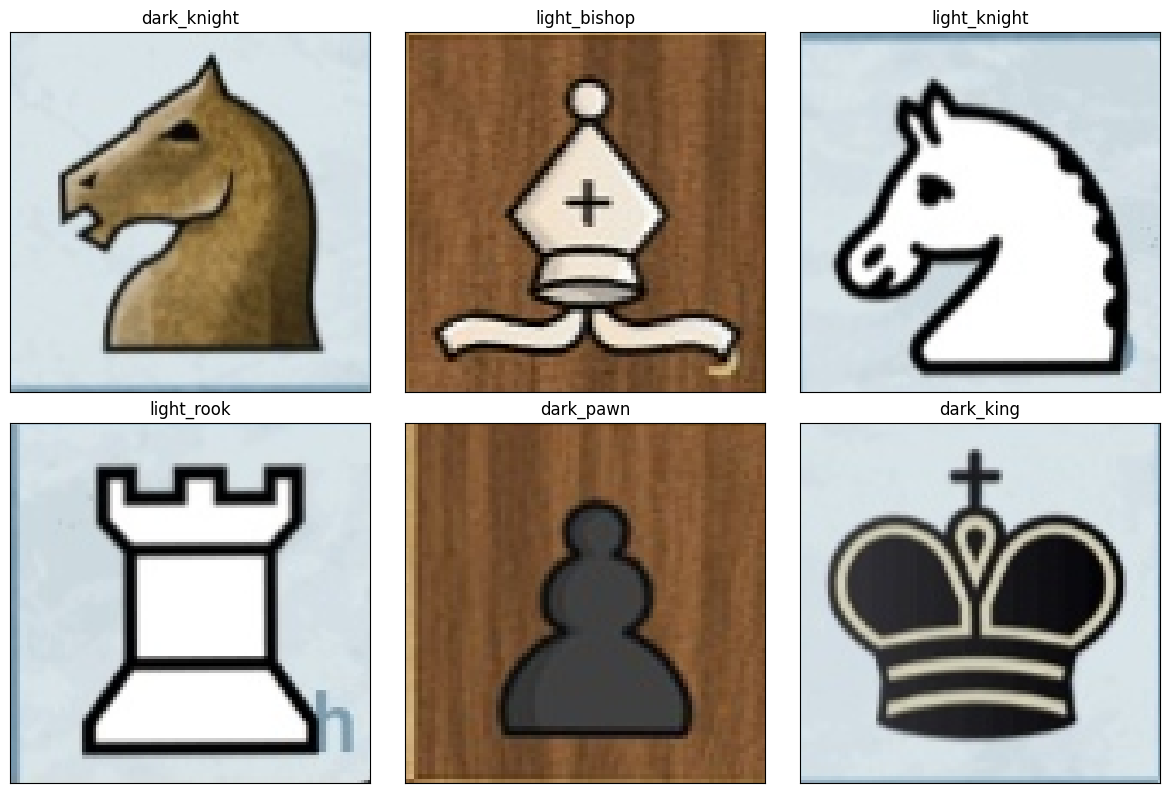

In [3]:
import random

# Select random samples from the dataset
sampled_df = df.sample(n=6, random_state=random.randint(0, 1000))

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                         subplot_kw={'xticks': [], 'yticks': []})

# Loop through subplots to display random images
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(sampled_df.files.iloc[i]))  # Read and display image
    ax.set_title(sampled_df.Pieces.iloc[i])  # Set label (chess piece name)

plt.tight_layout()
plt.show()


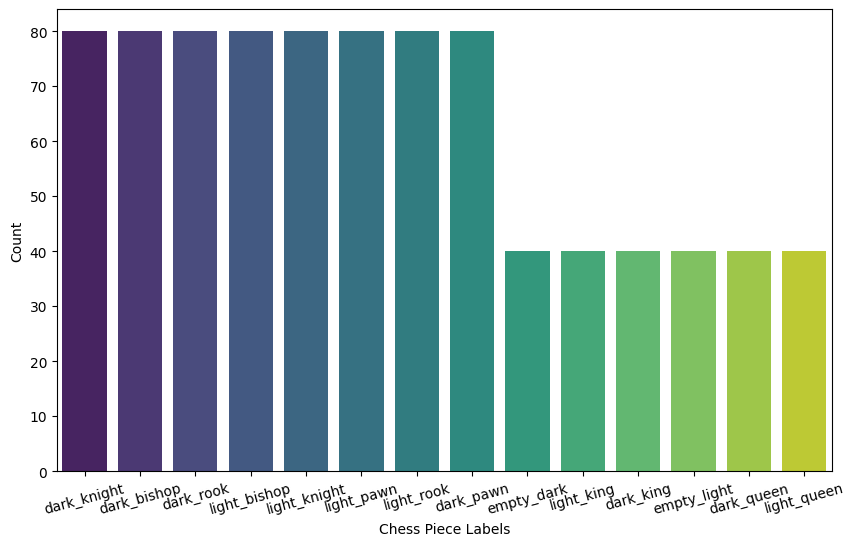

In [4]:
# Count occurrences of each chess piece type
counts = df.Pieces.value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=counts.index, y=counts.values, palette="viridis")

# Labeling the axes
plt.xlabel('Chess Piece Labels')
plt.ylabel('Count')
plt.xticks(rotation=15)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

## ✂️Splitting Training and Testing Data

In [5]:
# testing - 20 % testing on 80%
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


## 💾Transfer Learning Pipeline Function 

In [6]:
def train_and_evaluate_model(pre, name_model, size):
    print("\n" + "="*60)
    print("📌 Model Summary".center(60))
    print("="*60)
    print(f"• Base Model: {name_model.__name__}")
    print(f"• Input Image Size: {size}x{size}")
    print(f"• Number of Classes: 14")
    print("="*60 + "\n")
    
    # Data generators (no augmentation)
    datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)

    train_gen = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='files',
        y_col='Pieces',
        target_size=(size, size),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training')
    # This dict maps class_name → index
    print(train_gen.class_indices)

    valid_gen = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='files',
        y_col='Pieces',
        target_size=(size, size),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation')

    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='files',
        y_col='Pieces',
        target_size=(size, size),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False)
    
    # Load base model
    base_model = name_model(input_shape=(size, size, 3), include_top=False, weights='imagenet', pooling='avg')
    base_model.trainable = False

    # Custom classifier
    x = Dense(128, activation='relu')(base_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(14, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    print("\n🔄 Training in progress...\n")
    history = model.fit(train_gen, validation_data=valid_gen, epochs=100, callbacks=[early_stop], verbose=0)
    # saving the trained model
    model.save(f"{name_model.__name__}_model.h5")
    print(f"✅ Model saved as {name_model.__name__}_model.h5")

    # Plotting training history
    print("\n" + "="*60)
    print("📊 Training Curves".center(60))
    print("="*60)
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()
    for i, metric in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[metric])
        ax[i].plot(history.history['val_' + metric])
        ax[i].set_title(f'{metric.capitalize()}')
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(metric)
        ax[i].legend(['Train', 'Validation'])
    plt.tight_layout()
    plt.show()

    # Predictions
    print("\n🔍 Generating predictions...\n")
    pred_probs = model.predict(test_gen)
    pred_classes = np.argmax(pred_probs, axis=1)
    label_map = dict((v, k) for k, v in train_gen.class_indices.items())
    pred_labels = [label_map[k] for k in pred_classes]

    # Classification report
    print("\n" + "="*60)
    print("📄 Classification Report".center(60))
    print("="*60)
    print(classification_report(test_df.Pieces, pred_labels))

    # Show sample predictions
    print("\n🖼️  Sample Predictions")
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), subplot_kw={'xticks': [], 'yticks': []})
    for i, ax in enumerate(axes.flat):
        img_path = test_df.files.iloc[i]
        true_label = test_df.Pieces.iloc[i]
        pred_label = pred_labels[i]
        ax.imshow(plt.imread(img_path))
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")
    plt.tight_layout()
    plt.show()

    # Evaluation
    print("\n" + "="*60)
    print("📈 Final Evaluation on Test Set".center(60))
    print("="*60)
    results = model.evaluate(test_gen, verbose=0)
    print(f"• Test Loss     : \033[31m\033[1m{results[0]:.5f}\033[0m")
    print(f"• Test Accuracy : \033[32m\033[1m{results[1]*100:.2f}%\033[0m")
    print("="*60 + "\n")

    return results


## 🤖Training Different Models 

###  InceptionV3   


                      📌 Model Summary                       
• Base Model: InceptionV3
• Input Image Size: 100x100
• Number of Classes: 14

Found 564 validated image filenames belonging to 14 classes.
{'dark_bishop': 0, 'dark_king': 1, 'dark_knight': 2, 'dark_pawn': 3, 'dark_queen': 4, 'dark_rook': 5, 'empty_dark': 6, 'empty_light': 7, 'light_bishop': 8, 'light_king': 9, 'light_knight': 10, 'light_pawn': 11, 'light_queen': 12, 'light_rook': 13}
Found 140 validated image filenames belonging to 14 classes.
Found 176 validated image filenames belonging to 14 classes.


I0000 00:00:1751996021.706017      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

🔄 Training in progress...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1751996039.828293      62 service.cc:148] XLA service 0x7a47ec0035d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751996039.829244      62 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751996041.704443      62 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751996046.393028      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


✅ Model saved as InceptionV3_model.h5

                     📊 Training Curves                      


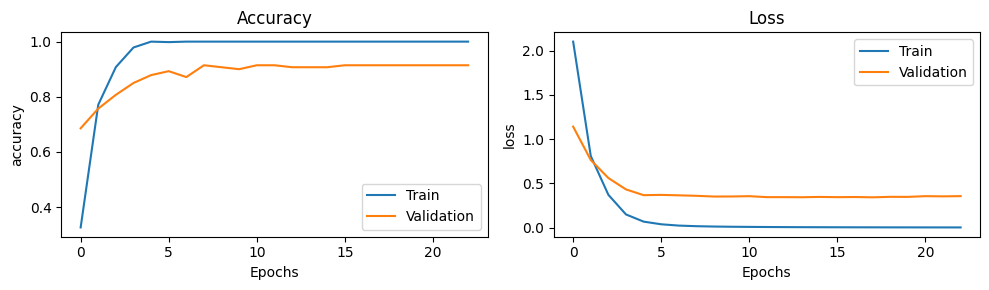


🔍 Generating predictions...

6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step

                  📄 Classification Report                   
              precision    recall  f1-score   support

 dark_bishop       0.64      0.70      0.67        10
   dark_king       1.00      1.00      1.00         6
 dark_knight       0.95      0.79      0.86        24
   dark_pawn       0.94      0.94      0.94        17
  dark_queen       1.00      0.67      0.80         6
   dark_rook       0.83      1.00      0.91        15
  empty_dark       1.00      1.00      1.00         6
 empty_light       1.00      1.00      1.00         8
light_bishop       0.94      0.83      0.88        18
  light_king       1.00      1.00      1.00         6
light_knight       0.86      0.90      0.88        21
  light_pawn       0.94      1.00      0.97        16
 light_queen       0.71      1.00      0.83         5
  light_rook       0.94      0.94      0.94        18

    accuracy                           0.90       176
   ma

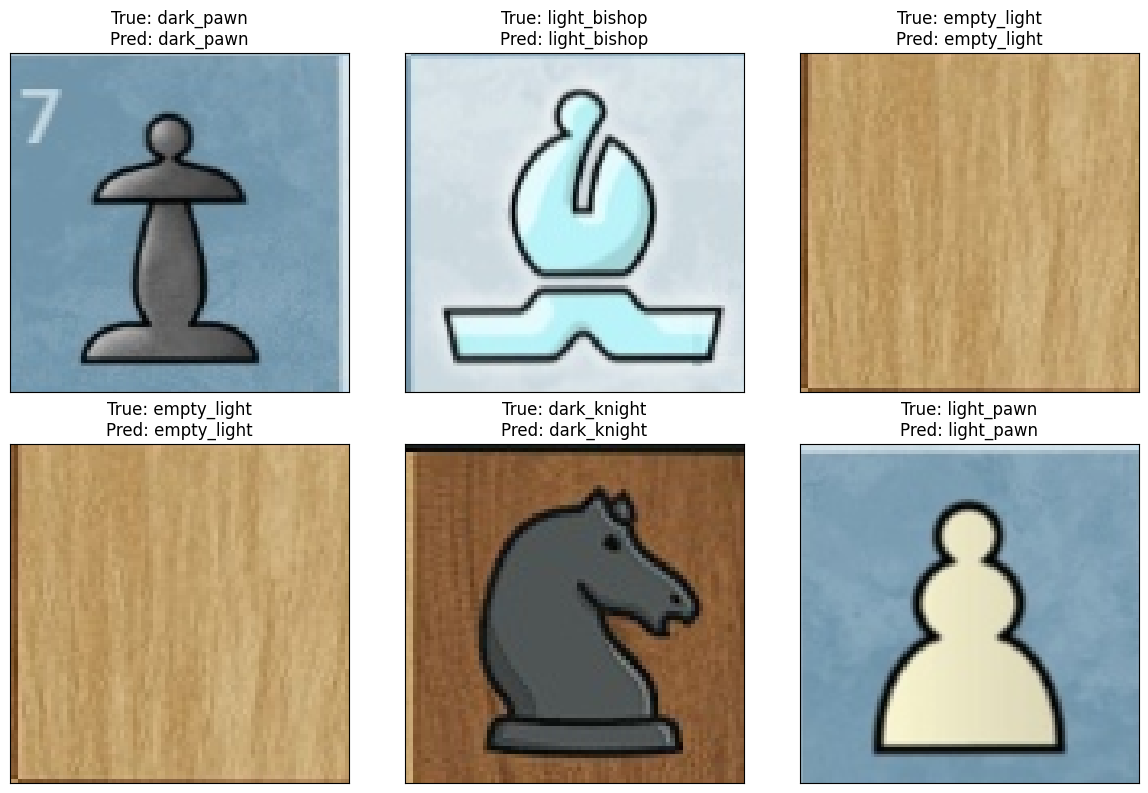


               📈 Final Evaluation on Test Set               
• Test Loss     : 0.29411
• Test Accuracy : 90.34%



In [7]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
result_InceptionV3 = train_and_evaluate_model(preprocess_input,InceptionV3,100)

##  NASNetMobile


                      📌 Model Summary                       
• Base Model: NASNetMobile
• Input Image Size: 224x224
• Number of Classes: 14

Found 564 validated image filenames belonging to 14 classes.
{'dark_bishop': 0, 'dark_king': 1, 'dark_knight': 2, 'dark_pawn': 3, 'dark_queen': 4, 'dark_rook': 5, 'empty_dark': 6, 'empty_light': 7, 'light_bishop': 8, 'light_king': 9, 'light_knight': 10, 'light_pawn': 11, 'light_queen': 12, 'light_rook': 13}
Found 140 validated image filenames belonging to 14 classes.
Found 176 validated image filenames belonging to 14 classes.
19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

🔄 Training in progress...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Model saved as NASNetMobile_model.h5

                     📊 Training Curves                      


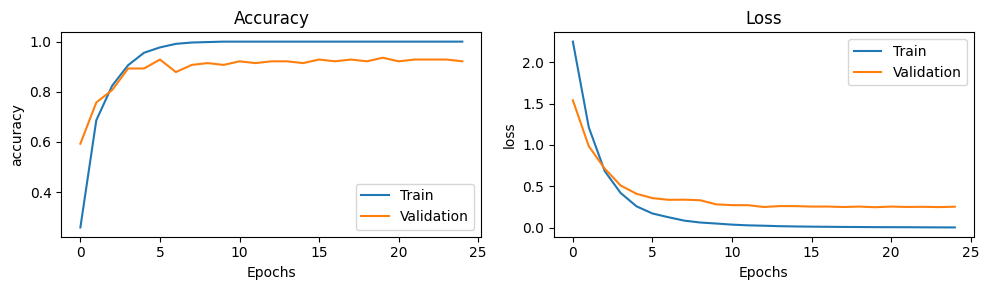


🔍 Generating predictions...

6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step

                  📄 Classification Report                   
              precision    recall  f1-score   support

 dark_bishop       0.83      1.00      0.91        10
   dark_king       1.00      1.00      1.00         6
 dark_knight       0.96      0.92      0.94        24
   dark_pawn       0.94      0.94      0.94        17
  dark_queen       1.00      0.83      0.91         6
   dark_rook       0.94      1.00      0.97        15
  empty_dark       1.00      1.00      1.00         6
 empty_light       1.00      1.00      1.00         8
light_bishop       1.00      0.83      0.91        18
  light_king       1.00      0.83      0.91         6
light_knight       0.91      0.95      0.93        21
  light_pawn       0.88      0.94      0.91        16
 light_queen       0.83      1.00      0.91         5
  light_rook       0.94      0.94      0.94        18

    accuracy                           0.94       176
   ma

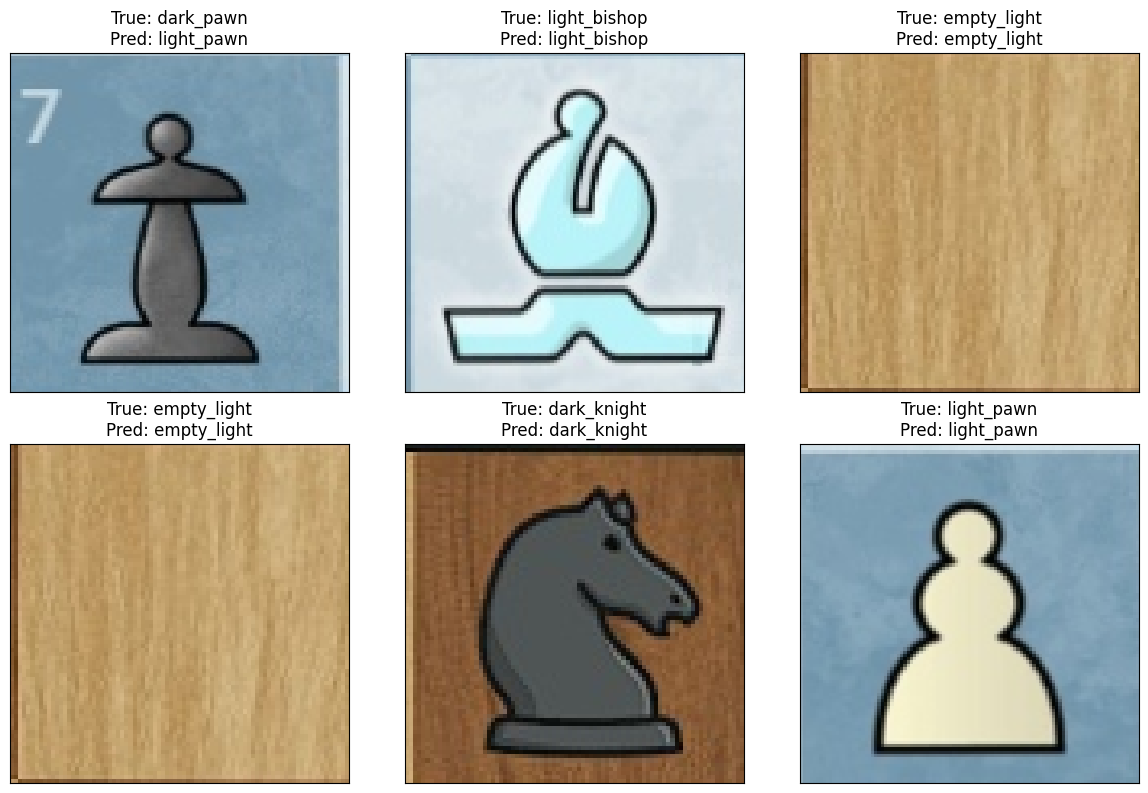


               📈 Final Evaluation on Test Set               
• Test Loss     : 0.18011
• Test Accuracy : 93.75%



In [8]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications.nasnet import preprocess_input
result_NASNetMobile = train_and_evaluate_model(preprocess_input,NASNetMobile,224)

## InceptionResNetV2


                      📌 Model Summary                       
• Base Model: InceptionResNetV2
• Input Image Size: 224x224
• Number of Classes: 14

Found 564 validated image filenames belonging to 14 classes.
{'dark_bishop': 0, 'dark_king': 1, 'dark_knight': 2, 'dark_pawn': 3, 'dark_queen': 4, 'dark_rook': 5, 'empty_dark': 6, 'empty_light': 7, 'light_bishop': 8, 'light_king': 9, 'light_knight': 10, 'light_pawn': 11, 'light_queen': 12, 'light_rook': 13}
Found 140 validated image filenames belonging to 14 classes.
Found 176 validated image filenames belonging to 14 classes.
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step

🔄 Training in progress...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Model saved as InceptionResNetV2_model.h5

                     📊 Training Curves                      


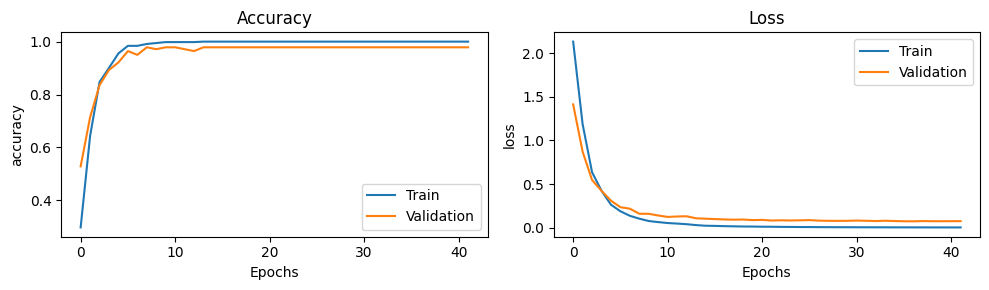


🔍 Generating predictions...

6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step

                  📄 Classification Report                   
              precision    recall  f1-score   support

 dark_bishop       0.90      0.90      0.90        10
   dark_king       0.80      0.67      0.73         6
 dark_knight       1.00      0.92      0.96        24
   dark_pawn       1.00      1.00      1.00        17
  dark_queen       0.71      0.83      0.77         6
   dark_rook       0.94      1.00      0.97        15
  empty_dark       1.00      1.00      1.00         6
 empty_light       1.00      1.00      1.00         8
light_bishop       0.95      1.00      0.97        18
  light_king       1.00      0.83      0.91         6
light_knight       0.91      1.00      0.95        21
  light_pawn       1.00      1.00      1.00        16
 light_queen       0.83      1.00      0.91         5
  light_rook       1.00      0.89      0.94        18

    accuracy                           0.95       176
   ma

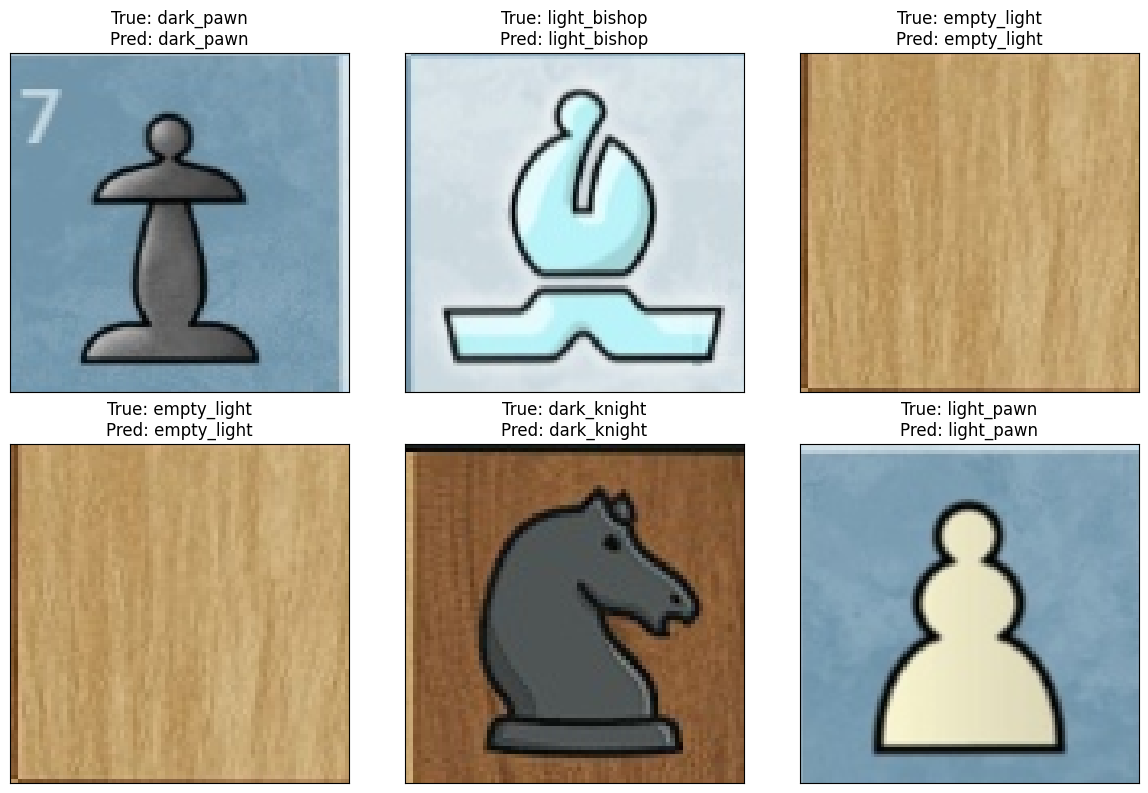


               📈 Final Evaluation on Test Set               
• Test Loss     : 0.11874
• Test Accuracy : 94.89%



In [9]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
result_InceptionResNetV2 = train_and_evaluate_model(preprocess_input,InceptionResNetV2,224)

## DenseNet201


                      📌 Model Summary                       
• Base Model: DenseNet201
• Input Image Size: 100x100
• Number of Classes: 14

Found 564 validated image filenames belonging to 14 classes.
{'dark_bishop': 0, 'dark_king': 1, 'dark_knight': 2, 'dark_pawn': 3, 'dark_queen': 4, 'dark_rook': 5, 'empty_dark': 6, 'empty_light': 7, 'light_bishop': 8, 'light_king': 9, 'light_knight': 10, 'light_pawn': 11, 'light_queen': 12, 'light_rook': 13}
Found 140 validated image filenames belonging to 14 classes.
Found 176 validated image filenames belonging to 14 classes.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

🔄 Training in progress...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Model saved as DenseNet201_model.h5

                     📊 Training Curves                      


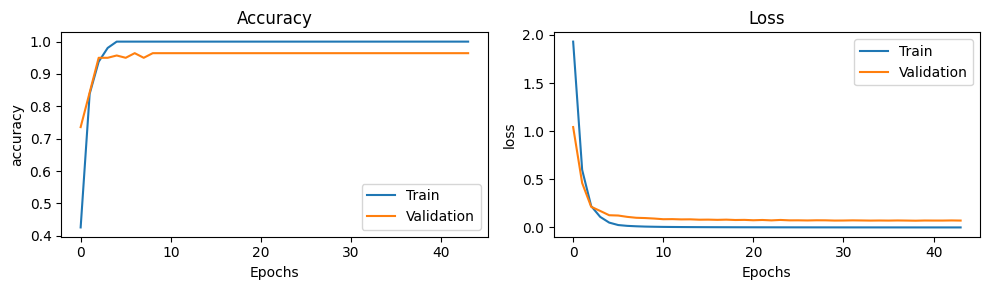


🔍 Generating predictions...

6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step

                  📄 Classification Report                   
              precision    recall  f1-score   support

 dark_bishop       0.77      1.00      0.87        10
   dark_king       0.80      0.67      0.73         6
 dark_knight       0.96      0.96      0.96        24
   dark_pawn       0.94      0.88      0.91        17
  dark_queen       1.00      0.83      0.91         6
   dark_rook       1.00      1.00      1.00        15
  empty_dark       1.00      1.00      1.00         6
 empty_light       1.00      1.00      1.00         8
light_bishop       1.00      1.00      1.00        18
  light_king       1.00      1.00      1.00         6
light_knight       0.95      0.95      0.95        21
  light_pawn       1.00      1.00      1.00        16
 light_queen       1.00      1.00      1.00         5
  light_rook       1.00      1.00      1.00        18

    accuracy                           0.96       176
   ma

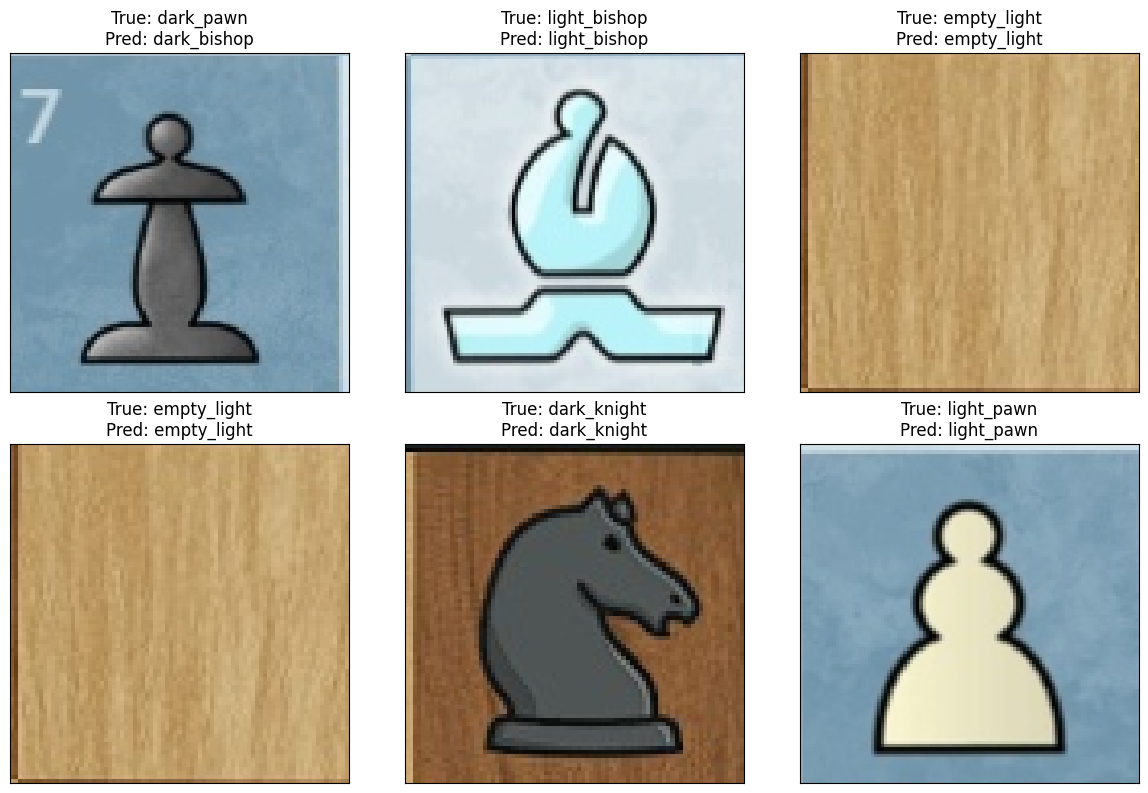


               📈 Final Evaluation on Test Set               
• Test Loss     : 0.08437
• Test Accuracy : 96.02%



In [10]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
result_DenseNet201 = train_and_evaluate_model(preprocess_input,DenseNet201,100)

##  NasNetLarge  


                      📌 Model Summary                       
• Base Model: NASNetLarge
• Input Image Size: 331x331
• Number of Classes: 14

Found 564 validated image filenames belonging to 14 classes.
{'dark_bishop': 0, 'dark_king': 1, 'dark_knight': 2, 'dark_pawn': 3, 'dark_queen': 4, 'dark_rook': 5, 'empty_dark': 6, 'empty_light': 7, 'light_bishop': 8, 'light_king': 9, 'light_knight': 10, 'light_pawn': 11, 'light_queen': 12, 'light_rook': 13}
Found 140 validated image filenames belonging to 14 classes.
Found 176 validated image filenames belonging to 14 classes.
343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step

🔄 Training in progress...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-07-08 17:47:11.214559: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[32,336,42,42]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1008,42,42]{3,2,1,0}, f32[336,1008,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-07-08 17:47:11.252204: E external/local_xla/xla/servic

✅ Model saved as NASNetLarge_model.h5

                     📊 Training Curves                      


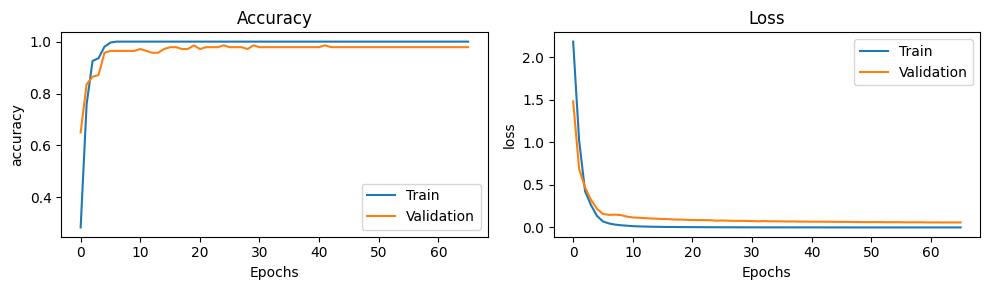


🔍 Generating predictions...

6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step

                  📄 Classification Report                   
              precision    recall  f1-score   support

 dark_bishop       1.00      1.00      1.00        10
   dark_king       0.86      1.00      0.92         6
 dark_knight       0.96      0.92      0.94        24
   dark_pawn       0.94      1.00      0.97        17
  dark_queen       0.80      0.67      0.73         6
   dark_rook       0.94      1.00      0.97        15
  empty_dark       1.00      1.00      1.00         6
 empty_light       1.00      1.00      1.00         8
light_bishop       1.00      1.00      1.00        18
  light_king       1.00      0.83      0.91         6
light_knight       0.91      0.95      0.93        21
  light_pawn       1.00      0.94      0.97        16
 light_queen       0.71      1.00      0.83         5
  light_rook       1.00      0.89      0.94        18

    accuracy                           0.95       176
   ma

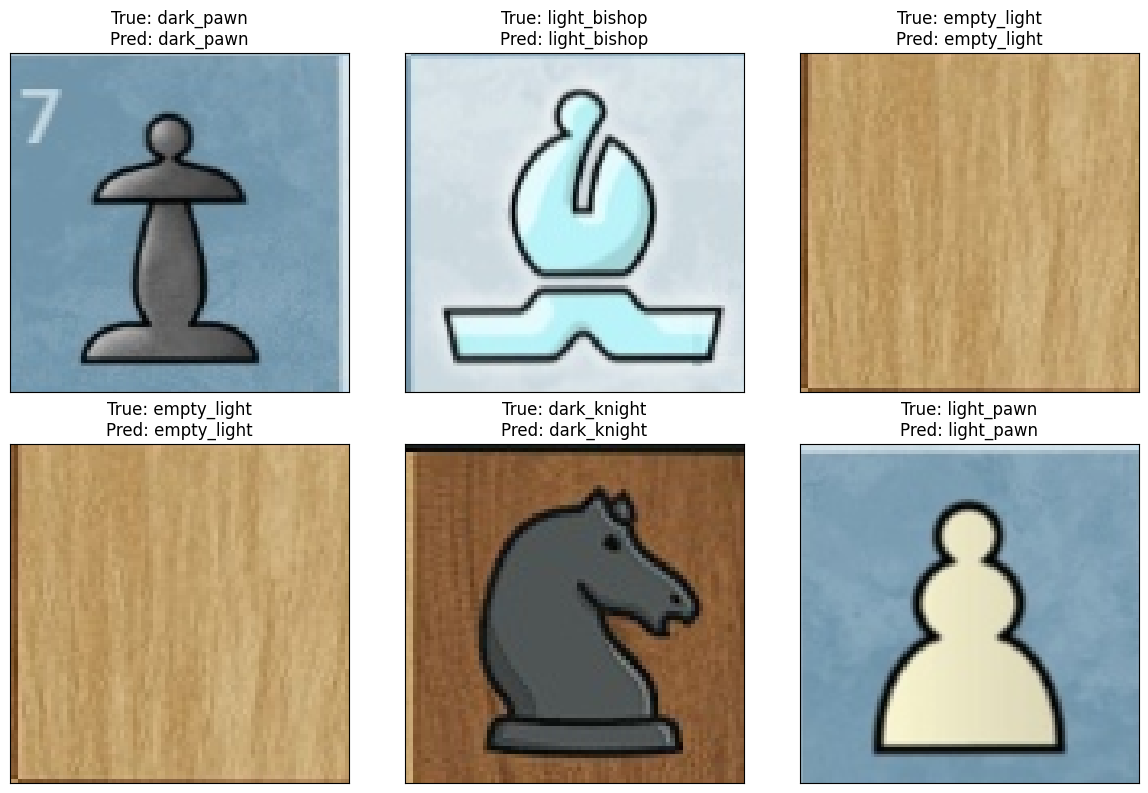


               📈 Final Evaluation on Test Set               
• Test Loss     : 0.13302
• Test Accuracy : 94.89%



In [11]:
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input
result_NASNetLarge = train_and_evaluate_model(preprocess_input,NASNetLarge,331)

## EfficientNetB7


                      📌 Model Summary                       
• Base Model: EfficientNetB7
• Input Image Size: 100x100
• Number of Classes: 14

Found 564 validated image filenames belonging to 14 classes.
{'dark_bishop': 0, 'dark_king': 1, 'dark_knight': 2, 'dark_pawn': 3, 'dark_queen': 4, 'dark_rook': 5, 'empty_dark': 6, 'empty_light': 7, 'light_bishop': 8, 'light_king': 9, 'light_knight': 10, 'light_pawn': 11, 'light_queen': 12, 'light_rook': 13}
Found 140 validated image filenames belonging to 14 classes.
Found 176 validated image filenames belonging to 14 classes.
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

🔄 Training in progress...



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


✅ Model saved as EfficientNetB7_model.h5

                     📊 Training Curves                      


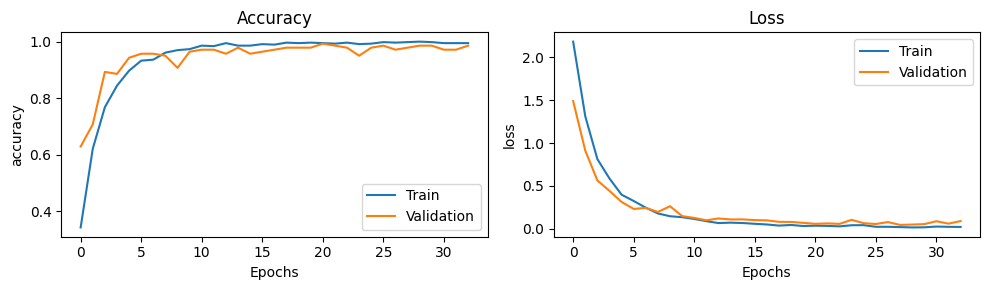


🔍 Generating predictions...

6/6 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step

                  📄 Classification Report                   
              precision    recall  f1-score   support

 dark_bishop       0.77      1.00      0.87        10
   dark_king       1.00      1.00      1.00         6
 dark_knight       1.00      0.92      0.96        24
   dark_pawn       1.00      0.94      0.97        17
  dark_queen       1.00      1.00      1.00         6
   dark_rook       1.00      1.00      1.00        15
  empty_dark       1.00      1.00      1.00         6
 empty_light       1.00      1.00      1.00         8
light_bishop       1.00      1.00      1.00        18
  light_king       1.00      1.00      1.00         6
light_knight       1.00      1.00      1.00        21
  light_pawn       1.00      1.00      1.00        16
 light_queen       1.00      1.00      1.00         5
  light_rook       1.00      1.00      1.00        18

    accuracy                           0.98       176
   ma

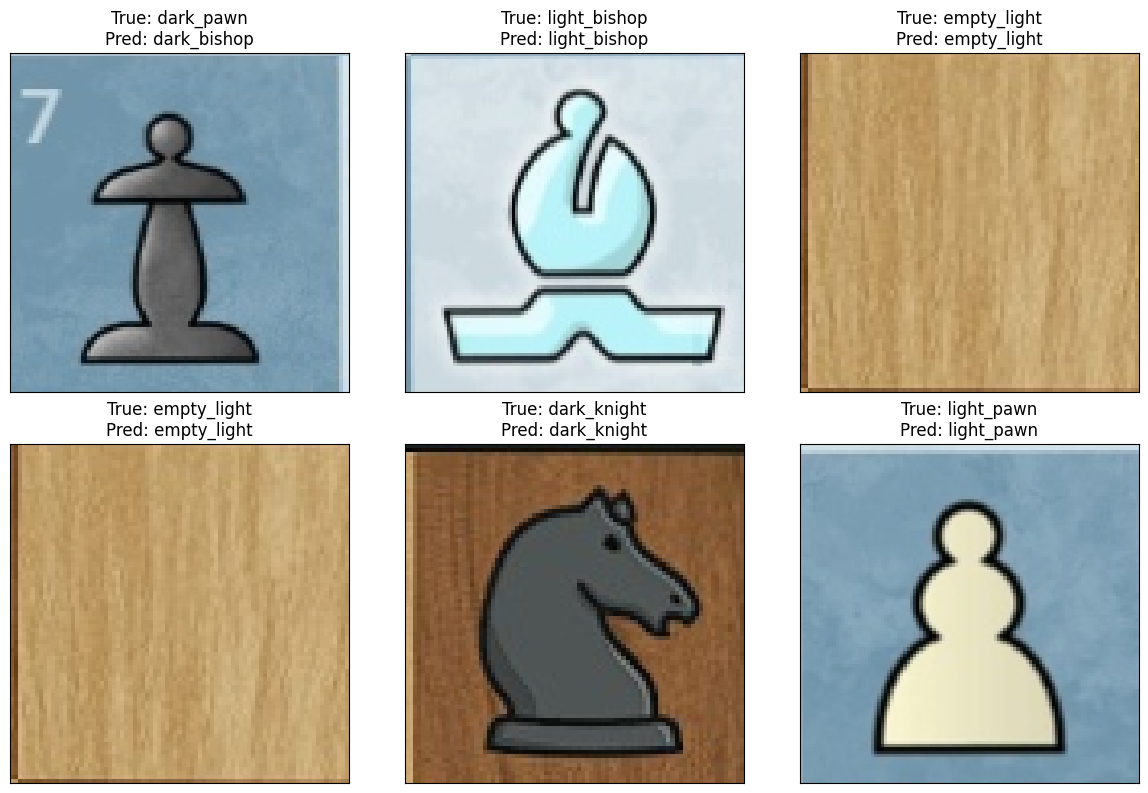


               📈 Final Evaluation on Test Set               
• Test Loss     : 0.08445
• Test Accuracy : 98.30%



In [12]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
result_EfficientNetB7 = train_and_evaluate_model(preprocess_input,EfficientNetB7,100)

## 📈Comparision and Conclusion

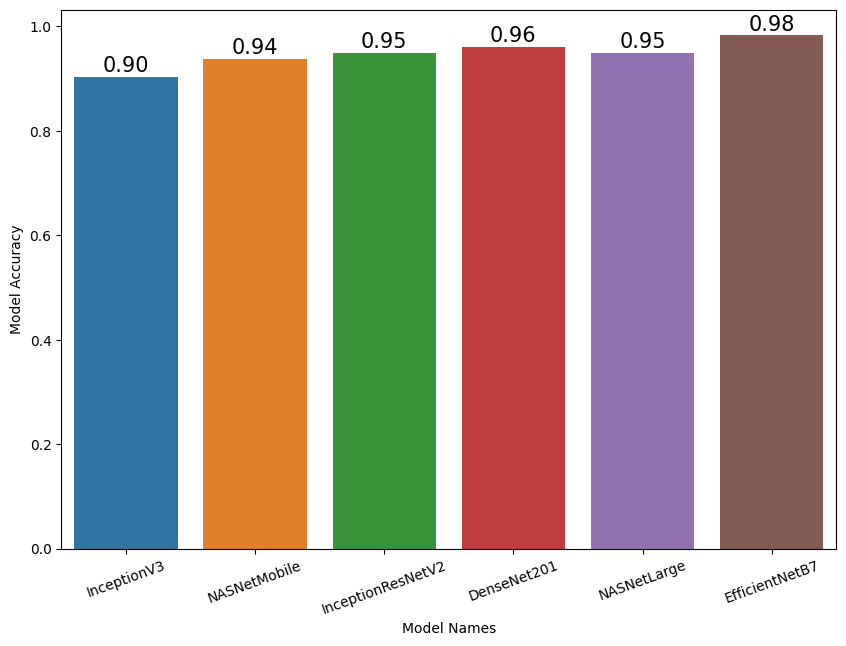

In [13]:
output = pd.DataFrame({'Models':['InceptionV3', 'NASNetMobile', 'InceptionResNetV2', 'DenseNet201', 'NASNetLarge', 'EfficientNetB7'],
                      'Accuracy':[result_InceptionV3[1], result_NASNetMobile[1], result_InceptionResNetV2[1],
                                  result_DenseNet201[1], result_NASNetLarge[1],result_EfficientNetB7[1]]})
plt.figure(figsize=(10, 7))
plots = sns.barplot(x='Models', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Model Names")
plt.ylabel("Model Accuracy")
plt.xticks(rotation=20);



## ⚓ Analyzing the Best Performing Model

✅ Model Performance Summary : (EfficientNetB7 on Digital Chess Pieces)

               📈 Model Evaluation on Test Set               
Found 176 validated image filenames belonging to 14 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step
• Test Loss     : 0.08445
• Test Accuracy : 98.30%


                     🤔 Confusion Matrix                     


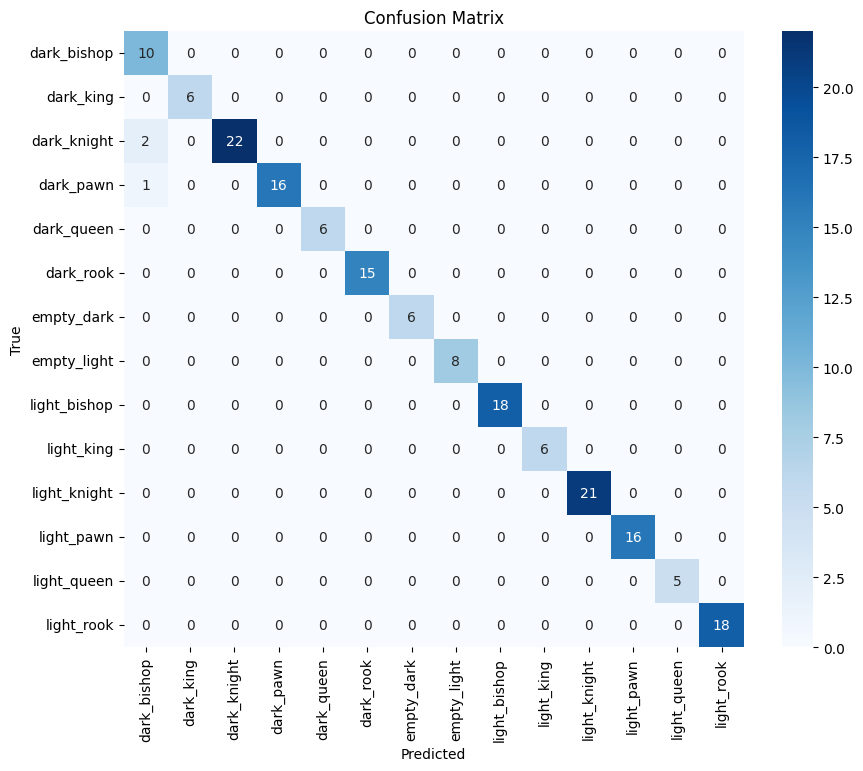


                  📄 Classification Report                   
              precision    recall  f1-score   support

 dark_bishop       0.77      1.00      0.87        10
   dark_king       1.00      1.00      1.00         6
 dark_knight       1.00      0.92      0.96        24
   dark_pawn       1.00      0.94      0.97        17
  dark_queen       1.00      1.00      1.00         6
   dark_rook       1.00      1.00      1.00        15
  empty_dark       1.00      1.00      1.00         6
 empty_light       1.00      1.00      1.00         8
light_bishop       1.00      1.00      1.00        18
  light_king       1.00      1.00      1.00         6
light_knight       1.00      1.00      1.00        21
  light_pawn       1.00      1.00      1.00        16
 light_queen       1.00      1.00      1.00         5
  light_rook       1.00      1.00      1.00        18

    accuracy                           0.98       176
   macro avg       0.98      0.99      0.99       176
weighted avg      

In [14]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.applications.efficientnet import preprocess_input as pre 


# Find the best‐performing model's name
best_idx        = output['Accuracy'].idxmax()
best_model_name = output.loc[best_idx, 'Models']
best_accuracy   = output.loc[best_idx, 'Accuracy']
# best_model_name = 'NASNetMobile'
model_path = f'/kaggle/working/{best_model_name}_model.h5'

model = load_model(model_path)

# Check architecture
# model.summary()

print(f"✅ Model Performance Summary : ({best_model_name} on Digital Chess Pieces)")
 # Evaluation
print("\n" + "="*60)
print("📈 Model Evaluation on Test Set".center(60))
print("="*60)


test_datagen = ImageDataGenerator(preprocessing_function=pre)
# Get the input shape (excluding batch size)
_, height, width, _ = model.input_shape  # e.g., (None, 224, 224, 3)


test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='files',
    y_col='Pieces',
    target_size=(height,width),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# Predict
predictions = model.predict(test_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)

# True labels as class indices
y_true = test_gen.classes

# Get class labels
class_labels = list(test_gen.class_indices.keys())


fresults = model.evaluate(test_gen, verbose=0)
print(f"• Test Loss     : \033[31m\033[1m{fresults[0]:.5f}\033[0m")
print(f"• Test Accuracy : \033[32m\033[1m{fresults[1]*100:.2f}%\033[0m")
print("="*60 + "\n")

# Confusion matrix
print("\n" + "="*60)
print("🤔 Confusion Matrix".center(60))
print("="*60)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

 # Classification report
print("\n" + "="*60)
print("📄 Classification Report".center(60))
print("="*60)

print(classification_report(y_true, y_pred, target_names=class_labels))



### 📊 **Where the Model Performs Well**

* The model **correctly classifies most chess piece images** with high confidence.
* From the **confusion matrix**, the majority of predictions fall along the diagonal — indicating strong generalization.

---

### ⚠️ **Where the Model Gets Confused**

* **Common confusions (based on confusion matrix):**

  * **Queen vs King**: Both pieces have visually similar crown structures; small resolution may blur fine details.
  * **Queen vs Bishop (sometimes)**: The model occasionally mistakes them.
* These confusions suggest the model **relies heavily on silhouette**, and when parts are occluded, it misclassifies.


## 🧩 Application: Chessboard Screenshot → FEN Notation

- Upload a screenshot of a chessboard.
- Segment it into 64 squares.
- Use the trained model to classify each square.
- Generate the FEN string.


## 🔪 Extracting the Board Image and Segmenting to 64 squares From Screenshot of Chess board

In [15]:
import os

os.makedirs('/kaggle/working/squares', exist_ok=True)
print("Created /kaggle/working/squares")

Created /kaggle/working/squares


In [16]:
import cv2
import numpy as np
import os
import glob 
from PIL import Image


def add_border_cv2(input_path: str,
                   border_size: int = 20,
                   bgr_color: tuple = (38, 36, 33)):
    # Load image
    img = cv2.imread(input_path)
    if img is None:
        raise FileNotFoundError(f"Cannot load image: {input_path}")

    # Add constant‐color border
    bordered = cv2.copyMakeBorder(
        img,
        top=border_size, bottom=border_size,
        left=border_size, right=border_size,
        borderType=cv2.BORDER_CONSTANT,
        value=bgr_color
    )

    # Save result
    cv2.imwrite(input_path, bordered)
    #print(f"Saved bordered image to {output_path}")

def add_sidebars_pillow(input_path, output_path, rgb_color=(38, 36, 33)):
    # Load the original image
    img = Image.open(input_path)
    w, h = img.size 

    # Create a new image: width = 3*w, height = h, filled with rgb_color
    new_w = w * 2
    canvas = Image.new("RGB", (new_w, h), rgb_color)

    # Paste the original image in the center
    canvas.paste(img, (int(w/2), 0))

    # Save the result
    canvas.save(output_path)


def composite_on_background(board_img: np.ndarray,
                            background_path: str) -> np.ndarray:
    """
    Load the RGBA background (with transparent hole) and
    composite `board_img` (any size) into that hole.
    Returns the BGR composite.
    """
    # 1) load background with alpha
    bg_rgba = cv2.imread(background_path, cv2.IMREAD_UNCHANGED)
    if bg_rgba is None or bg_rgba.shape[2] != 4:
        raise ValueError(f"Background must be a 4-channel PNG: {background_path}")

    # 2) find hole’s bbox in alpha channel
    alpha = bg_rgba[:, :, 3]
    ys, xs = np.where(alpha == 0)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()

    # 3) resize board_img to hole size
    hole_h, hole_w = (y1 - y0 + 1, x1 - x0 + 1)
    board_resized = cv2.resize(board_img, (hole_w, hole_h))

    # 4) composite into bg (drop alpha)
    composite = bg_rgba[:, :, :3].copy()
    composite[y0:y1+1, x0:x1+1] = board_resized

    return composite

def process_image(image_path: str,
                  background_path: str = "/kaggle/input/boardimages/back.png",
                  output_path: str   = "/kaggle/working/output.png",
                  tol: float         = 0.05) -> None:
    """
    Load image_path → if its shape is nearly square (within tol),
    composite it on background_path → save to output_path.
    Otherwise, just save the original to output_path.
    
    tol = relative tolerance, e.g. 0.03 means 3% difference allowed.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Cannot load {image_path}")

    h, w = img.shape[:2]
    rel_diff = abs(h - w) / max(h, w)

    if rel_diff <= tol:
        # nearly square → composite
        print(f"Image is nearly square (h={h}, w={w}, Δ={rel_diff:.3f}); applying background.")
        result = composite_on_background(img, background_path)
    else:
        # not square → leave as is
        print(f"Image not square enough (h={h}, w={w}, Δ={rel_diff:.3f}); skipping background.")
        result = img

    cv2.imwrite(output_path, result)
    print(f"Saved result to {output_path}")

def find_chessboard(image_path, debug=False):
    """
    Find and extract a chessboard from an image.
    Returns the warped top-down view of the chessboard.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise Exception(f"Could not load image from {image_path}")
    h, w = image.shape[:2]
    ratio = w / h
    if abs(ratio - 1) <= 0.2 : # Check if the image is nearly square and pass it to the process_image function
      add_border_cv2(image_path)
      process_image(image_path)
      image = cv2.imread("/kaggle/working/output.png")
    else :   # If the image is not nearly square, add sidebars for better processing
      add_sidebars_pillow(image_path, "/kaggle/working/output.png")
      image = cv2.imread("/kaggle/working/output.png")

    
    if image is None:
        raise Exception(f"Could not load image from ")
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply adaptive thresholding instead of simple blur
    # This helps with different lighting conditions
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                  cv2.THRESH_BINARY, 11, 2)
    
    # Use Canny edge detection with different parameters
    edges = cv2.Canny(thresh, 50, 150)
    
   
    # Find contours with different retrieval mode for better results
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours by area (largest first)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # Look for board contour among top candidates
    board_contour = None
    for contour in contours[:10]:  # Check top 10 contours
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        
        # Check if it's a quadrilateral
        if len(approx) == 4:
            # Additional check: verify it's roughly square-shaped
            rect = cv2.minAreaRect(contour)
            width, height = rect[1]
            if width > 0 and height > 0:
                aspect_ratio = max(width, height) / min(width, height)
                # Accept if aspect ratio is close to 1 (square)
                if 0.8 <= aspect_ratio <= 1.2:
                    board_contour = approx
                    break
    
    if board_contour is None:
        raise Exception("Chessboard not found.")
    
    

    # Improved point ordering for perspective transform
    rect = order_points(board_contour)
    (tl, tr, br, bl) = rect
    
    # Calculate the width of the new image
    width_a = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width_b = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width_a), int(width_b))
    
    # Calculate the height of the new image
    height_a = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height_b = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height_a), int(height_b))
    
    # Ensure square output for the chessboard
    side = max(max_width, max_height)
    
    dst = np.array([
        [0, 0],
        [side - 1, 0],
        [side - 1, side - 1],
        [0, side - 1]
    ], dtype="float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (side, side))
   
    
    return warped


def order_points(pts):
    """
    Order points in clockwise order starting from top-left.
    Important for correct perspective transform.
    """
    # Convert to the right format
    if len(pts) == 4:
        pts = pts.reshape(4, 2)
    
    rect = np.zeros((4, 2), dtype="float32")
    
    # The top-left point will have the smallest sum
    # The bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right
    
    # The top-right point will have the smallest difference
    # The bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    
    return rect


def extract_squares(board_img):
    """Extract individual squares from a chessboard image"""
    # Ensure the image is square by using the minimum dimension
    # min_dim = min(board_img.shape[0], board_img.shape[1])
    # board_img = board_img[:min_dim, :min_dim]
    
    square_size = board_img.shape[0] // 8
    squares = []
    
    for row in range(8):
        for col in range(8):
            square = board_img[
                row * square_size:(row + 1) * square_size,
                col * square_size:(col + 1) * square_size
            ]
            squares.append(square)
    
    return squares

# Main processing
if __name__ == "__main__":
    # Process a single image
    ###################################################################################################
    image_path = '/kaggle/input/boardimages/test2.png'  
    ###################################################################################################
    
    debug_mode = True  
    try:
        # Find and extract the chessboard
        board_img = find_chessboard(image_path, debug=debug_mode)
        # Save the warped, top-down board as "board.png"
        cv2.imwrite('/kaggle/working/board.png', board_img)
        print("Saved extracted board to board.png")
        # Extract individual squares
        squares = extract_squares(board_img)
        # print(squares)
              
        # Save the squares
        for idx, square in enumerate(squares):
            square_img = Image.fromarray(cv2.cvtColor(square, cv2.COLOR_BGR2RGB))
            output_path = f'/kaggle/working/squares/square_{idx}.png'
            square_img.save(output_path)
       
        print(f"Successfully processed {image_path}")
        
    except Exception as e:
        print(f"Error processing image: {e}")


Saved extracted board to board.png
Successfully processed /kaggle/input/boardimages/test2.png


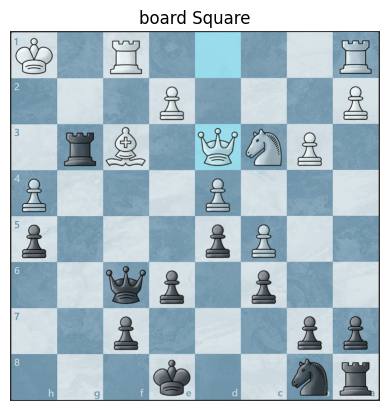

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/kaggle/working/board.png')  # change filename as needed
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.title("board Square")
plt.show()

## 🧮 Predicting Each Squares by The Best Model

In [18]:
import os
import glob
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# best_model_name = 'EfficientNetB7'
# 1. Configuration: paths & model parameters
print(f"Loading Model :  {best_model_name}")
MODEL_PATH    = f'/kaggle/working/{best_model_name}_model.h5'
IMAGE_FOLDER  = '/kaggle/working/squares'
BATCH_NORMAL  = 1.0 / 255.0

# 2. Load your trained model
model = load_model(MODEL_PATH)
# Get the input shape (excluding batch size)
input_shape = model.input_shape  # e.g., (None, 224, 224, 3)

TARGET_SIZE   = input_shape[1:3]
#3.define class names
class_names = [
    'dark_bishop',   # 0
    'dark_king',     # 1
    'dark_knight',   # 2
    'dark_pawn',     # 3
    'dark_queen',    # 4
    'dark_rook',     # 5
    'empty',         # 6
    'empty',         # 7
    'light_bishop',  # 8
    'light_king',    # 9
    'light_knight',  #10
    'light_pawn',    #11
    'light_queen',   #12
    'light_rook'     #13
]

# 4. Gather all image file paths
file_paths = glob.glob(os.path.join(IMAGE_FOLDER, '*'))
file_paths = [p for p in file_paths if p.lower().endswith(('.png','.jpg','.jpeg'))]

# 5. Run inference on each image
records = []
for fp in file_paths:
    # 5.1 Load & preprocess
    img = load_img(fp, target_size=TARGET_SIZE)
    arr = img_to_array(img) * BATCH_NORMAL
    arr = np.expand_dims(arr, axis=0)           # shape: (1, H, W, 3)

    # 5.2 Predict
    preds   = model.predict(arr)                # shape: (1, num_classes)
    idx     = np.argmax(preds, axis=1)[0]       # predicted class index
    prob    = float(preds[0, idx])              # confidence         # shape: (1, num_classes)
    num_classes = preds.shape[1]
   
    
    # print("Model predicts", num_classes, "classes, class_names has", len(class_names))
    # print("Predicted idx:", idx)

   # 5.3 Record results
    records.append({
        'file_path'       : fp,
        'predicted_class' : class_names[idx],
        'confidence'      : round(prob, 4)
    })

# 6. Build a DataFrame & display
df = pd.DataFrame(records)
df.info()
df.head()
# 7. Save the predictions into output.csv
df.to_csv('/kaggle/working/output.csv', index=True)

Loading Model :  EfficientNetB7
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━

## ⚡ Visualizing Prediction

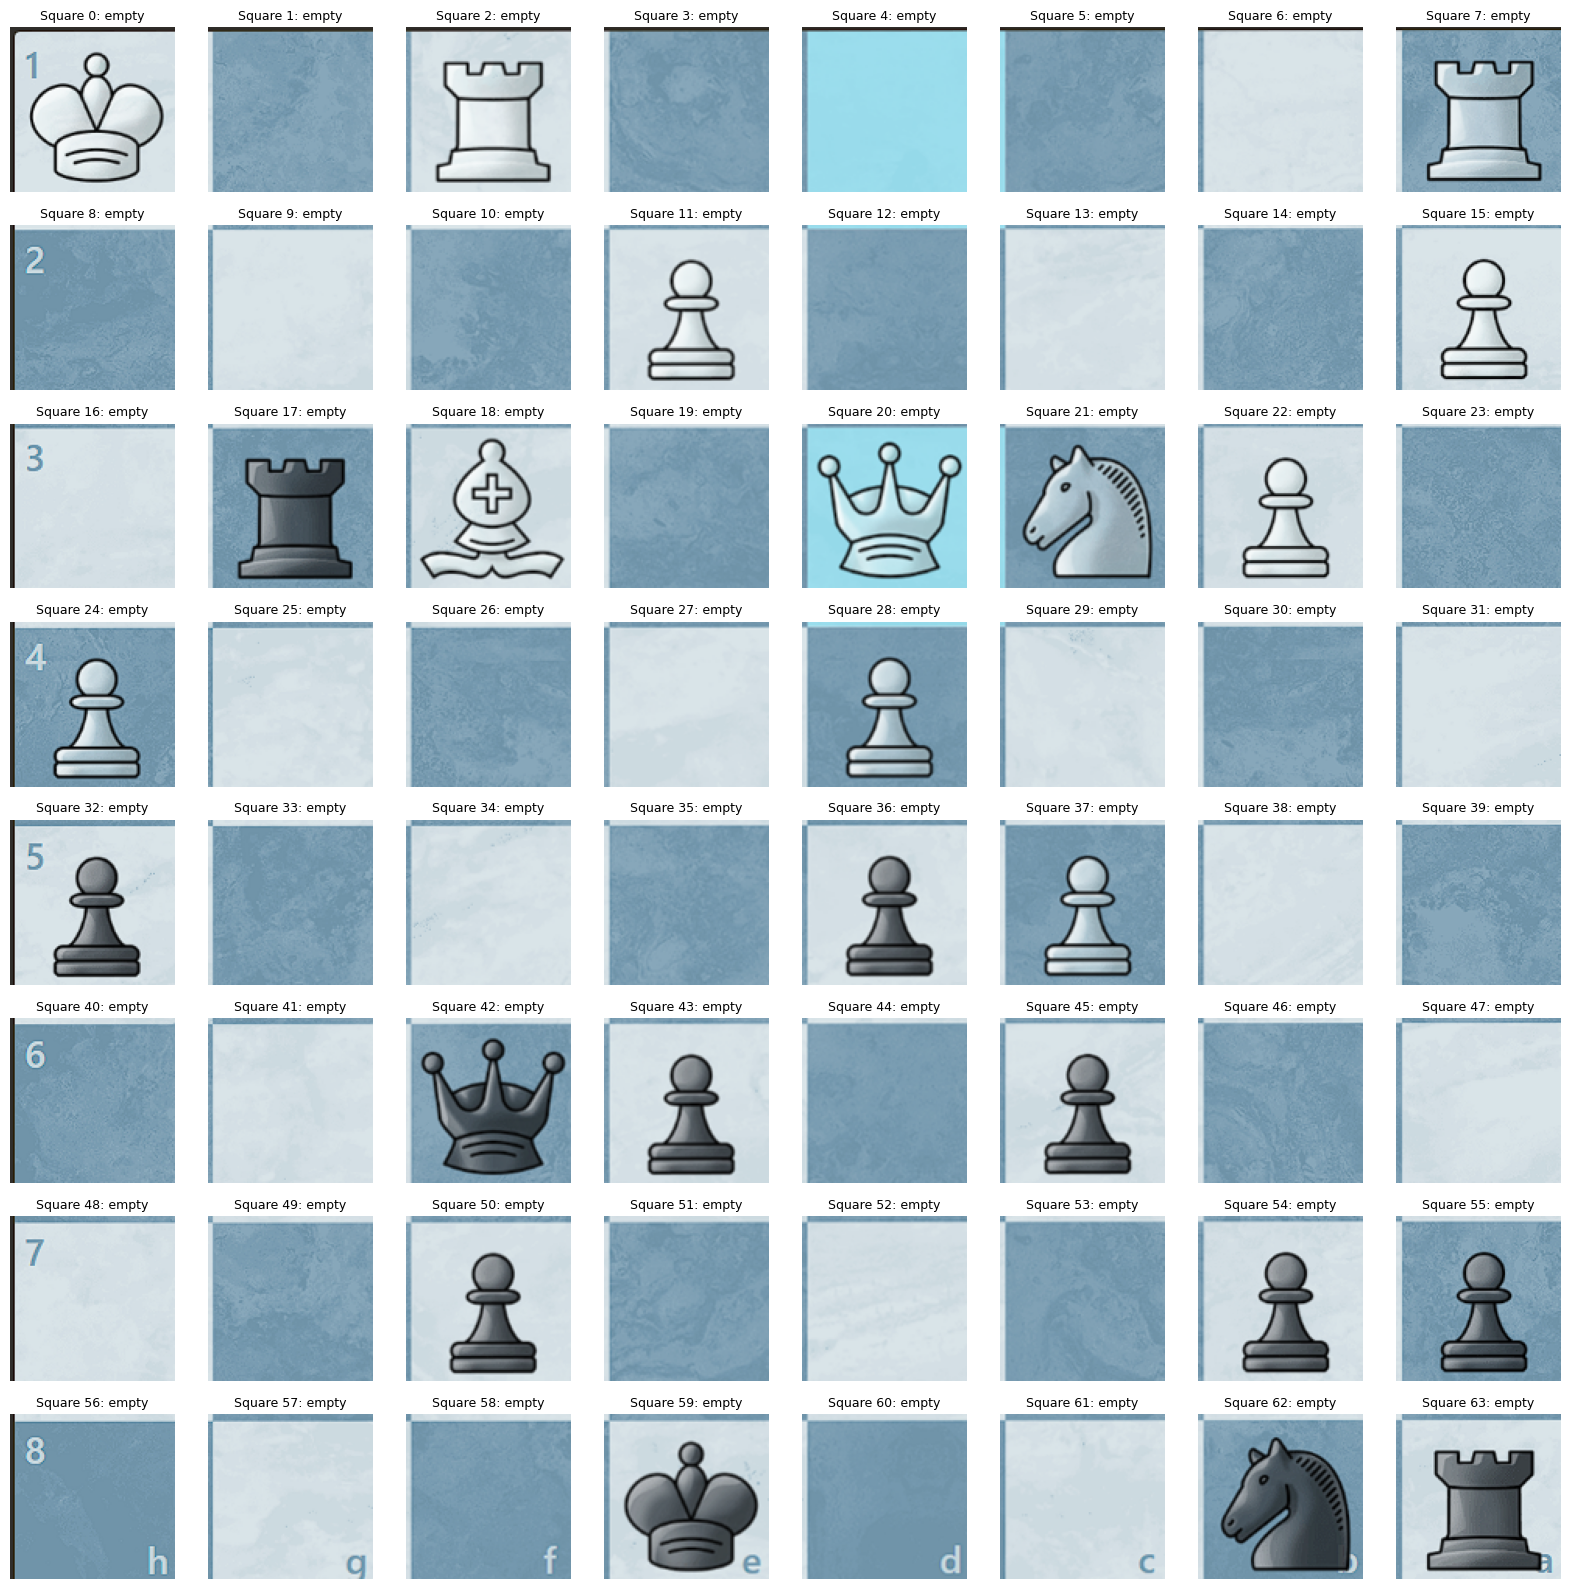

In [19]:
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

# Paths
image_folder = '/kaggle/working/squares'
csv_path     = '/kaggle/working/output.csv'

# Compile a regex that matches filenames like "square_55.png"
pattern = re.compile(r'square_(\d+)\.png$', re.IGNORECASE)

# Load predictions and extract the square number
pred_df = pd.read_csv(csv_path)

pred_df['square_number'] = pred_df['file_path'].apply(
    lambda p: int(pattern.search(os.path.basename(p)).group(1))
)
pred_map = dict(zip(pred_df['square_number'], pred_df['predicted_class']))

# Gather (square_num, filename) pairs for only the matching files
files_with_nums = []
for fname in os.listdir(image_folder):
    m = pattern.match(fname)
    if m:
        num = int(m.group(1))
        files_with_nums.append((num, fname))

# Sort by square number
files_with_nums.sort(key=lambda x: x[0])

# Prepare plot grid
assert len(files_with_nums) == 64, "Expected 64 images for an 8x8 board"
n_cols   = 8
n_rows   = 8
plt.figure(figsize=(16,16))

# Display each image with its prediction
for idx, (square_num, fname) in enumerate(files_with_nums):
    img = Image.open(os.path.join(image_folder, fname))
    pred = pred_map.get(square_num, "No prediction")

    ax = plt.subplot(n_rows, n_cols, idx + 1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Square {square_num}: {pred}", fontsize=9)

plt.tight_layout()
plt.show()


## ✅ Generating FEN Notation

In [20]:
import pandas as pd
from itertools import groupby  # Import groupby from itertools
def board_to_fen(rows):
    
    fen_rows = []

    for row in rows:
        fen_row = ""
        empty_count = 0
        for char in row:
            if char == '1':
                empty_count += 1
            else:
                if empty_count > 0:
                    fen_row += str(empty_count)
                    empty_count = 0
                fen_row += char
        if empty_count > 0:
            fen_row += str(empty_count)
        fen_rows.append(fen_row)

    return '/'.join(fen_rows)
    
# Define class names mapping to FEN symbols
class_to_fen = {
    'dark_bishop': 'b',   # dark pieces (lowercase)
    'dark_king': 'k',
    'dark_knight': 'n',
    'dark_pawn': 'p',
    'dark_queen': 'q',
    'dark_rook': 'r',
    'empty': '1',    # empty dark and light squares
       
    'light_bishop': 'B',  # light pieces (uppercase)
    'light_king': 'K',
    'light_knight': 'N',
    'light_pawn': 'P',
    'light_queen': 'Q',
    'light_rook': 'R'
}
df = pred_df
# Sort by square_number for clarity
df_sorted = df.sort_values(by='square_number')

df = df_sorted[['predicted_class', 'square_number']]

# Initialize empty chessboard (64 squares)
board = [' '] * 64

# Map the predicted class names to the FEN symbols
for _, row in df.iterrows():
    class_name = row['predicted_class']
    square_number = row['square_number']
    
    # Get the corresponding FEN symbol
    fen_symbol = class_to_fen.get(class_name, ' ')
    # print(fen_symbol)
    # Place the symbol on the chessboard at the correct square
    board[square_number] = fen_symbol
rows = []
for i in range(8):
    row = board[i*8:(i+1)*8]  # Get the current rank (row)
    row_str = ''.join(row)
    rows.append(row_str)
    #print(row_str)
    
fen = board_to_fen(rows)
print(f'Fen : {fen}')  # Output: rnbkkbnr/pppppppp/8/8/8/8/PPPPpPPP/RnBKkBnR


Fen : 8/8/8/8/8/8/8/8



---

# 🎉 Thank You! 🎉

---

## 🙏 Heartfelt Gratitude 🙏

Thank you for following along this **Digital Chess Pieces Classification** journey. Your time, curiosity, and passion for melding computer vision with chess fuel every line of code and each model tweak.  

🧑‍💻 Whether you’re here to refine the architecture, perfect the FEN conversion, or simply learn something new, your engagement makes this project shine brighter.  

♟️ Don’t hesitate to fork, comment, and share your own improvements—collaboration is the true checkmate to stagnation.

---

## 🚀 Keep Innovating! 🚀

🌟 Happy Coding & Good Luck on Your Next Move! 🌟

♟️♞♝♛♚♟️♞♝♛♚♟️♞♝♛♚
